## Airsoft Target Detection

In [216]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
from skimage import io


def show_image(img, cmap=None, name=None, size=None):
    if size is not None:
        plt.figure(figsize=size)
    else:
        plt.figure(figsize=(3,3))
    if cmap is not None:
        plt.imshow(img, cmap=cmap)
    else:
        plt.imshow(img)
    plt.axis('off')
    if name is not None:
        plt.title(name)
    plt.show()

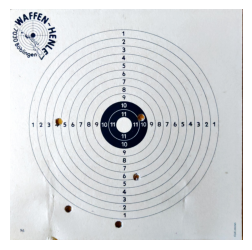

(2273, 2291, 3)

In [217]:
image = io.imread('resources/aligned/shot_1.jpg')
#image = cv2.resize(image, (0, 0), fx=0.35, fy=0.35)
show_image(image)
image.shape

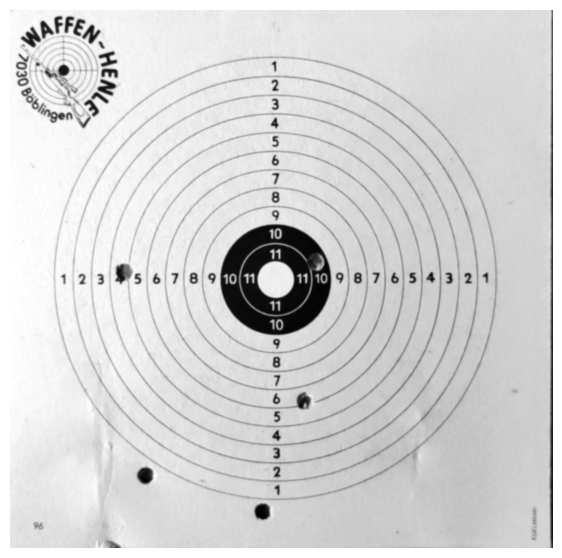

In [218]:
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
kernel = np.ones((5, 5), np.uint8)  
#gray_image = cv2.erode(gray_image, kernel)
gray_image = cv2.GaussianBlur(gray_image, (15,15), 0)
# gray_image = cv2.bitwise_not(gray_image) 
# gray_image = cv2.resize(gray_image, (0, 0), fx=0.35, fy=0.35)
show_image(gray_image, cmap='gray', size=(7,7))

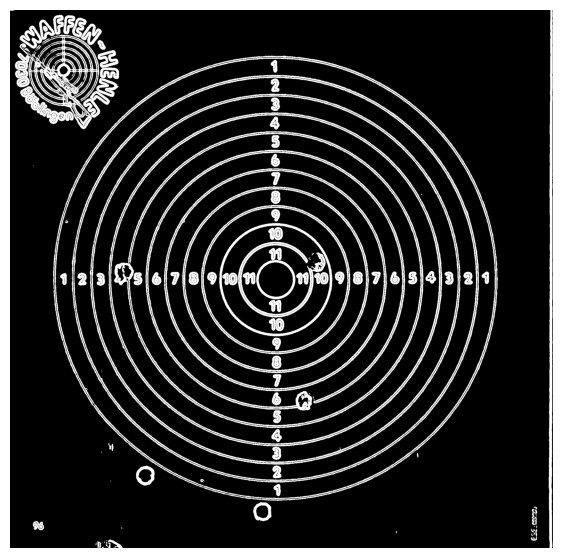

In [219]:
# canny = cv2.Canny(image=gray_image, threshold1=35, threshold2=200)

sobelx = cv2.Sobel(gray_image, cv2.CV_64F, 1, 0, ksize=3)
sobely = cv2.Sobel(gray_image, cv2.CV_64F, 0, 1, ksize=3)
sobel = cv2.magnitude(sobelx, sobely)

# Normalize and threshold the result
sobel = cv2.normalize(sobel, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
threshold = 40
sobel[sobel < threshold] = 0
sobel[sobel >= threshold] = 255
canny = sobel
# canny = io.imread('resources/aligned/test.png')
# canny = cv2.cvtColor(canny, cv2.COLOR_BGR2GRAY)
show_image(canny, cmap='gray', size=(7,7))

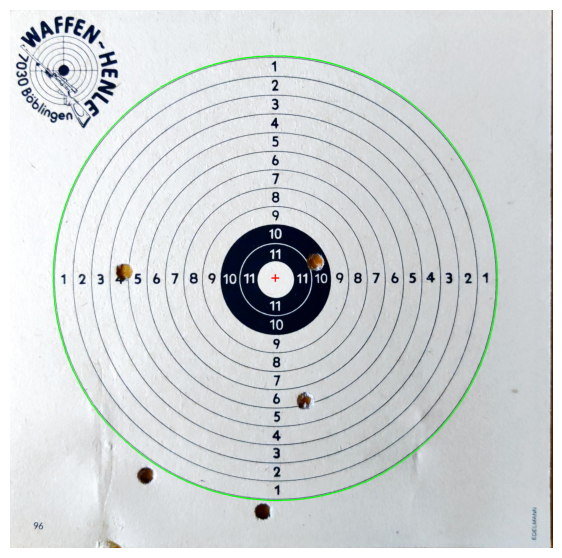

In [220]:
# find the biggest contour
contours, hierarchy = cv2.findContours(canny, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
biggest_cntr = None
biggest_radius = 0
marked = image.copy()
for contour in contours:
    # cv2.drawContours(marked, [contour], -1, (0, 255, 255), 3)
    radius = cv2.minEnclosingCircle(contour)[1]
    area = cv2.contourArea(contour)
    total = area * radius
    if total > biggest_radius:
        biggest_radius = total
        biggest_cntr = contour

cv2.drawContours(marked, [biggest_cntr], -1, (0, 255, 0), 3)

# find center of countour

(centerX, centerY), biggest_radius = cv2.minEnclosingCircle(biggest_cntr)

# convert center position to integers
centerX = int(centerX)
centerY = int(centerY)

cv2.drawMarker(marked, (centerX, centerY), (255, 0, 0), markerType=cv2.MARKER_CROSS, markerSize=30, thickness=3, line_type=cv2.LINE_AA)
show_image(marked, size=(7,7))

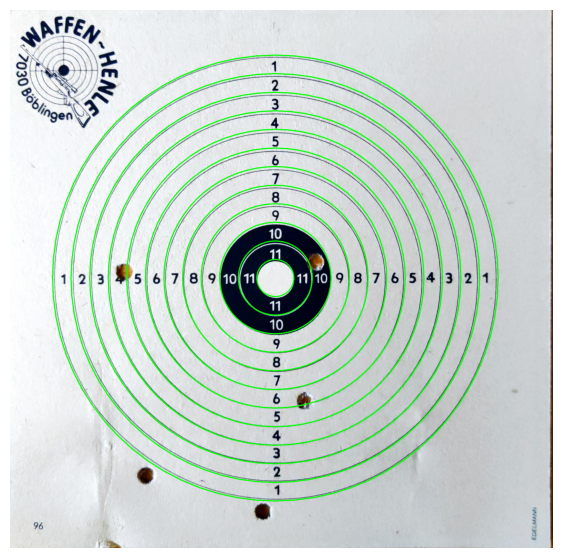

In [221]:
marked = image.copy()
for i in range(1, 13):
    cv2.circle(marked, (centerX, centerY), int(biggest_radius * i / 12), (0, 255, 0), 3)
show_image(marked, size=(7,7))

In [222]:
# draw the 

In [223]:
# # find the contours that have a similar center
# marked = image.copy()
# similar_contours = []
# color_index = 0
# # filter contours by center and radius
# for contour in contours:
#     # find center of countour and radius
#     (cX, cY), radius = cv2.minEnclosingCircle(contour)
#     cX = int(cX)
#     cY = int(cY)
    
#     if not(abs(centerX - cX) < 10 and abs(centerY - cY) < 10):
#         continue        
#     if any(abs(radius - similar_contour[1]) < 15 for similar_contour in similar_contours):
#         continue
#     # draw circles
#     cv2.circle(marked, (cX, cY), int(radius), (0,255,0), 3)
#     similar_contours.append(((cX, cY), radius))
# show_image(marked, size=(7,7))

4


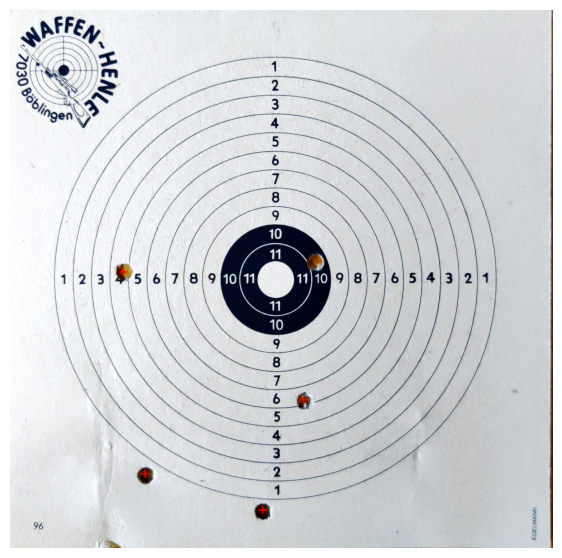

In [224]:
import cv2
import numpy as np

# Load reference images
templates = []
for i in range(1, 6):
    template = cv2.cvtColor(
        io.imread(f'resources/shots/hole_{1}.jpg'), cv2.COLOR_BGR2GRAY)
    templates.append(template)

# Define ROI for templates (assuming circular bullet holes)
roi_radius = 20
roi_mask = np.zeros((roi_radius*2, roi_radius*2), dtype=np.uint8)
cv2.circle(roi_mask, (roi_radius, roi_radius), roi_radius, 255, -1)
marked = image.copy()
# Match templates
hits = []
for i, template in enumerate(templates):
    # # Resize template to match size of ROI
    # template_roi = cv2.resize(template, (roi_radius*2, roi_radius*2))
    # # Apply ROI mask to template
    # template_roi = cv2.bitwise_and(template_roi, roi_mask)
    # Match template to image
    result = cv2.matchTemplate(gray_image, template, cv2.TM_CCOEFF_NORMED)
    # Threshold result to find matches
    threshold = 0.8
    matches = np.where(result >= threshold)  # type: ignore

    # Draw circles around matches
    w, h = template.shape[::-1]
    w = int(w/2)
    h = int(h/2)
    for pt in zip(*matches[::-1]):
        hits.append((pt[0] + w, pt[1] + h))

filtered_hits = []

for hit in hits:
    if any(abs(hit[0] - filtered_hit[0]) < 20 and abs(hit[1] - filtered_hit[1]) < 20 for filtered_hit in filtered_hits):
        continue
    filtered_hits.append(hit)

# draw all hits
for hit in filtered_hits:
    cv2.drawMarker(marked, hit, (255, 0, 0), markerType=cv2.MARKER_CROSS, markerSize=30, thickness=3, line_type=cv2.LINE_AA)

print(len(filtered_hits))
# Show result
show_image(marked, size=(7, 7))